In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import collections
import functools
from functools import partial
import itertools
import math

# visualization libraries
%matplotlib inline
from pprint import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import skimage
import torch
import torch.nn.functional as F
import functorch
import einops
import monai
import dipy
import dipy.reconst
import dipy.reconst.csdeconv, dipy.reconst.shm, dipy.viz
import dipy.denoise
import nibabel as nib

import jax

# Enable 64-bit precision.
import jax.config

# jax.config.update("jax_disable_jit", True)
# jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_default_matmul_precision", 32)
import jax.numpy as jnp
from jax import lax
import jax.dlpack

import pitn


plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})
plt.rcParams.update({"image.interpolation": "antialiased"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

In [2]:
hcp_full_res_data_dir = Path("/data/srv/data/pitn/hcp")
hcp_full_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/full-res/fodf")
hcp_low_res_data_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/vol")
hcp_low_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/fodf")

assert hcp_full_res_data_dir.exists()
assert hcp_full_res_fodf_dir.exists()
assert hcp_low_res_data_dir.exists()
assert hcp_low_res_fodf_dir.exists()

## fODF Peak Finding

In [3]:
sample_fod_f = (
    hcp_full_res_fodf_dir / "162329" / "T1w" / "postproc_wm_msmt_csd_fod.nii.gz"
)
fod_coeff_im = nib.load(sample_fod_f)
fod_coeff_im = nib.as_closest_canonical(fod_coeff_im)
mask_f = sample_fod_f.parent / "postproc_nodif_brain_mask.nii.gz"
mask_im = nib.load(mask_f)
mask_im = nib.as_closest_canonical(mask_im)

# Pre-select voxels of interest for this specific subject.
# CC forceps minor, strong L-R uni-modal lobe
cc_lr_lobe_idx = (55, 98, 53)
# Dual-polar approx. equal volume fiber crossing
lr_and_ap_bipolar_lobe_idx = (70, 106, 54)
# Vox. adjacent to CST, tri-polar
tri_polar_lobe_idx = (60, 68, 43)

In [4]:
coeffs = fod_coeff_im.get_fdata()
coeffs = torch.from_numpy(coeffs)
# Move to channels-first layout.
coeffs = coeffs.movedim(-1, 0)
mask = mask_im.get_fdata().astype(bool)
mask = torch.from_numpy(mask)[None]

print(coeffs.shape)
print(mask.shape)

torch.Size([45, 110, 134, 108])
torch.Size([1, 110, 134, 108])


In [ ]:
# # Change orientation for visualization.
# new_ornt = nib.orientations.axcodes2ornt(tuple("IPR"))
# ornt_tf = nib.orientations.ornt_transform(
#     nib.orientations.axcodes2ornt(nib.orientations.aff2axcodes(fod_coeff_im.affine)), new_ornt
# )
# coeffs = fod_coeff_im.as_reoriented(ornt_tf).get_fdata()
# coeffs = torch.from_numpy(coeffs)
# # Move to channels-first layout.
# coeffs = coeffs.movedim(-1, 0)
# mask = mask_im.as_reoriented(ornt_tf).get_fdata().astype(bool)
# mask = torch.from_numpy(mask)[None]

# print(coeffs.shape)
# print(mask.shape)

# # Transform the points of interest to the new coord layout.
# print("\nTransforming voxel coordinates of interest.")
# affine_vox2ras_phys = fod_coeff_im.affine
# affine_vox2ipr_phys = fod_coeff_im.as_reoriented(ornt_tf).affine
# affine_ipr_phys2vox = np.linalg.inv(affine_vox2ipr_phys)
# p_vox_ipr = list()
# for p in (cc_lr_lobe_idx, lr_and_ap_bipolar_lobe_idx, tri_polar_lobe_idx):
#     p = np.asarray(p)[:, None]
#     p_phys = (affine_vox2ras_phys[:3, :3] @ p) + affine_vox2ras_phys[:3, 3:4]
#     p_orient = (affine_ipr_phys2vox[:3, :3] @ p_phys) + affine_ipr_phys2vox[:3, 3:4]
#     print(p_orient.flatten().astype(int))
#     p_vox_ipr.append(tuple(p_orient.flatten().astype(int)))
# cc_lr_lobe_idx, lr_and_ap_bipolar_lobe_idx, tri_polar_lobe_idx = tuple(p_vox_ipr)
# print(cc_lr_lobe_idx, lr_and_ap_bipolar_lobe_idx, tri_polar_lobe_idx)

In [130]:
# sphere = dipy.data.HemiSphere.from_sphere(dipy.data.get_sphere("repulsion200"))
sphere = dipy.data.HemiSphere.from_sphere(
    dipy.data.get_sphere("repulsion724")
).subdivide(1)

theta, phi = pitn.odf.get_torch_sample_sphere_coords(
    sphere, coeffs.device, coeffs.dtype
)
with torch.no_grad():
    # Function applies non-negativity constraint.
    sphere_samples = pitn.odf.sample_sphere_coords(
        coeffs, theta=theta, phi=phi, sh_order=8, sh_order_dim=0, mask=mask
    )

nearest_sphere_samples = pitn.odf.adjacent_sphere_points_idx(theta=theta, phi=phi)
nearest_sphere_samples_idx = nearest_sphere_samples[0]
nearest_sphere_samples_valid_mask = nearest_sphere_samples[1]

### Fast-Marching Level Set (FMLS) Segmentation

In [131]:
# From
# R. E. Smith, J.-D. Tournier, F. Calamante, and A. Connelly,
# "SIFT: Spherical-deconvolution informed filtering of tractograms," NeuroImage,
# vol. 67, pp. 298–312, Feb. 2013, doi: 10.1016/j.neuroimage.2012.11.049.

# Single voxel lobe segmentation
# vox_idx = cc_lr_lobe_idx
# vox_idx = lr_and_ap_bipolar_lobe_idx
vox_idx = tri_polar_lobe_idx

# Algorithm 1. in Appendix A of the SIFT paper.
peak_diff_threshold = 0.8
min_lobe_pdf_peak_threshold = 1e-5
min_lobe_pdf_integral_threshold = 0.05

s = torch.clone(sphere_samples[(slice(None),) + vox_idx])

# Perform basic thresholding of the sample to remove noise.
# Normalize to a pdf to keep threshold values standardized across fodfs.
s_pdf = s - s.min()
s_pdf = s_pdf / s_pdf.sum()
s = torch.where(s_pdf >= 0.001, s, 0)
s_pdf = s - s.min()
s_pdf = s_pdf / s_pdf.sum()

lobe_labels = torch.zeros_like(s).to(torch.int16)
lobe_labels_index_space = torch.arange(lobe_labels.shape[0])

# Directions are sorted by absolute value, but the sign of their absolute value
# will be needed later.
# Get the indices of the sorted sample values, with each idx indexing into the
# directions/sample values on the spherical function.
sort_sample_idx = torch.argsort(torch.abs(s), dim=0, descending=True)
sort_sample_val = torch.gather(s, 0, sort_sample_idx)

curr_max_lobe_label = lobe_labels.new_tensor([0])
for i_sample, fod_sample, sample_idx in zip(
    range(s.shape[-1]),
    sort_sample_val[..., None],
    sort_sample_idx[..., None],
):
    i_sample_mask = lobe_labels_index_space == sample_idx
    # Get the 6 directions closest to the current sample direction by providing the
    # current sample's index over the spherical function samples. These adjacent
    # indices correspond to the unsorted sample values and unsorted theta/phi sphereical
    # coordinates.
    sample_adj_idx = nearest_sphere_samples_idx[sample_idx].flatten()
    sample_adj = torch.gather(s, 0, sample_adj_idx)
    # Adjacent lobe labels
    lobe_label_adj = torch.gather(lobe_labels, 0, sample_adj_idx)
    # Some adjacent samples should not be considered such as when taking a sample from
    # a hemisphere near the equator.
    sample_adj_valid = nearest_sphere_samples_valid_mask[sample_idx].squeeze(0)

    lobe_label_adj = lobe_label_adj * sample_adj_valid
    # Find the number of adjacent lobes in such a way that is compatible with
    # functorch.vmap().
    # Sort the lobe labels themselves and and take the diff. The number of non-zero
    # diffs is equal to the number of unique labels, +/- 1. The +/- 1 is determined
    # by whether or not a $label_{l=0} - label_{l\neq0}$ is responsible for one of the
    # diffs being non-zero.
    n_unique_adj_lobe_labels = (
        (torch.diff(lobe_label_adj.sort().values) != 0).sum()
        + 1
        - 1 * (lobe_label_adj == 0).any(-1)  # indicator for any 0s being present.
    )

    # Now handle the 3 conditionals without any 'if' statements!
    # 1. If no lobes are adjacent to this sample.
    no_lobes_adj = torch.atleast_1d(n_unique_adj_lobe_labels == 0)
    no_lobes_adj = i_sample_mask * no_lobes_adj
    # If 0 lobes are adjacent, create a new lobe label and iterate on it.
    # The masked_scatter_ in-place function is the best way to do assignment without
    # casting Tensor indices to tuples, while combining multiple conditions...
    lobe_labels.masked_scatter_(no_lobes_adj, curr_max_lobe_label + 1)
    curr_max_lobe_label.masked_scatter_(no_lobes_adj.any(), curr_max_lobe_label + 1)

    # 2. If 1 lobe is adjacent to this sample.
    one_lobe_adj = torch.atleast_1d(n_unique_adj_lobe_labels == 1)
    one_lobe_adj = i_sample_mask * one_lobe_adj
    # If only 1 lobe is adjacent, assign the max (i.e., non-zero) adj lobe label.
    lobe_labels.masked_scatter_(one_lobe_adj, lobe_label_adj.max())

    # 3. If > 1 lobe is adjacent to this sample.
    else_gt_1_lobe_adj = torch.atleast_1d(n_unique_adj_lobe_labels > 1)
    else_gt_1_lobe_adj = i_sample_mask * else_gt_1_lobe_adj
    # A 2D mask of n_samples x m_adj_samples can contain a label value/mask of all
    # samples that correspond to a label value, for all adjacent samples.
    adj_lobe_sample_mask = (
        lobe_labels.expand(lobe_label_adj.shape[-1], -1).T == lobe_label_adj
    ) * (lobe_label_adj != 0)
    # For the samples adjacent to sample i, collect the samples that have previously
    # been assigned a valid label.
    samples_of_adj_lobe_labels = torch.masked_fill(
        s.expand(lobe_label_adj.shape[-1], -1).T, ~adj_lobe_sample_mask, torch.nan
    )
    # Equivilent to a `nanmax` function.
    adj_peaks = torch.nanquantile(samples_of_adj_lobe_labels, 1.0, dim=0)
    adj_peaks = torch.nan_to_num(adj_peaks, nan=-torch.inf)
    # adj_peaks = torch.masked.amax(samples_of_adj_lobe_labels, dim=-1)
    adj_lobe_labels_idx_sorted_by_peaks = torch.argsort(adj_peaks)
    # The min lobe label must not be 0, so we need to select the first non-zero lobe
    # label. If there are 0 or 1 adjacent lobes, then we won't actually use this result,
    # and instead consider *all* as unique lobes, and just grab a dummy index instead.
    # Indexes into the original list of adjacent samples/directions.
    min_lobe_label_adj_idx = torch.cat(
        torch.where(
            ~else_gt_1_lobe_adj.any(-1)  # prevents empty tensors when <= 1 adj lobes
            | (lobe_label_adj[adj_lobe_labels_idx_sorted_by_peaks] != 0)
        ),
    )[0]
    # Need both the smallest adjacent lobe (and its label), and the peak of that lobe.
    min_lobe_label_adj = torch.gather(
        lobe_label_adj[adj_lobe_labels_idx_sorted_by_peaks], 0, min_lobe_label_adj_idx
    )
    min_lobe_adj_peak = torch.gather(
        adj_peaks[adj_lobe_labels_idx_sorted_by_peaks], 0, min_lobe_label_adj_idx
    )
    # We know that there exist at least 2 valid lobe labels, so select the label
    # with the max peak.
    max_lobe_label_adj = lobe_label_adj[adj_lobe_labels_idx_sorted_by_peaks][-1]
    r = fod_sample / min_lobe_adj_peak.clamp_min(1e-6)
    # 3.1 The difference between the current sample and the smallest peak of the
    # adjacent lobes is < the user-defined threshold.
    lobe_labels.masked_scatter_(
        else_gt_1_lobe_adj & (r < peak_diff_threshold), max_lobe_label_adj
    )

    # 3.2 Same comparison as 3.1, but >= the user-defined threshold.
    # Merge into the largest adjacent lobe, to keep the lobe indices sorted by peak
    # values.
    lobe_labels.masked_scatter_(
        else_gt_1_lobe_adj & (r >= peak_diff_threshold), max_lobe_label_adj
    )
    # If the sample_i has > 1 adjacent lobes
    # AND the ratio exceeds the threshold
    # AND for each lobe label, is the label in the set of adjacent labels
    # AND for each lobe label, is the label not 0
    # then assign to the largest adjacent lobe.
    lobe_labels.masked_scatter_(
        else_gt_1_lobe_adj.any(-1)
        & (r >= peak_diff_threshold)
        & torch.isin(lobe_labels, lobe_label_adj)
        & (lobe_labels != 0),
        max_lobe_label_adj.expand(lobe_labels.shape[-1]),
    )

print("Pre-filter unique lobes:", torch.unique(lobe_labels).shape)
###! The below code does not work with vmap()
# Filter out lobes that don't meet some criteria
ll = torch.clone(lobe_labels[None])
batch_s = s[None]
batch_s_pdf = s_pdf[None]
orig_unique_ll = ll.unique(dim=1)
lobe_peaks = torch.zeros_like(orig_unique_ll).float()
lobe_integrals = torch.zeros_like(orig_unique_ll).float()
lobe_pdf_peaks = torch.zeros_like(orig_unique_ll).float()
lobe_pdf_integrals = torch.zeros_like(orig_unique_ll).float()
for i in range(orig_unique_ll.shape[1]):
    l = orig_unique_ll[:, i]
    # print(l.item(), end=" ")
    select_s = torch.where(ll == l, batch_s, torch.nan)
    select_s_pdf = torch.where(ll == l, batch_s_pdf, torch.nan)
    # print(ll == l, end=" ")
    lobe_peaks[:, i] = torch.nanquantile(select_s, 1.0, dim=1)
    lobe_pdf_peaks[:, i] = torch.nanquantile(select_s_pdf, 1.0, dim=1)
    # print(lobe_peaks[:, i], end=" ")
    lobe_integrals[:, i] = torch.nansum(select_s, dim=1)
    lobe_pdf_integrals[:, i] = torch.nansum(select_s_pdf, dim=1)
    lobe_labels_to_remove_mask = ~(select_s.isnan()) & (
        (lobe_pdf_peaks[:, i] < min_lobe_pdf_peak_threshold)
        | (lobe_pdf_integrals[:, i] < min_lobe_pdf_integral_threshold)
    )
    ll[lobe_labels_to_remove_mask] = 0

    new_select_s = torch.where((ll == l) & (ll != 0), batch_s, torch.nan)
    new_select_s_pdf = torch.where((ll == l) & (ll != 0), batch_s_pdf, torch.nan)
    # print(ll == l, end=" ")
    lobe_peaks[:, i] = torch.nanquantile(new_select_s, 1.0, dim=1)
    lobe_pdf_peaks[:, i] = torch.nanquantile(new_select_s, 1.0, dim=1)
lobe_peaks.nan_to_num_(nan=-torch.inf)
lobe_pdf_peaks.nan_to_num_(nan=0)

# Re-map labels to be evenly-spaced, ascending index, in order of largest lobe
# peak to smallest lobe peak. Performs batch-wise.
sorted_lobe_peaks_idx = torch.argsort(lobe_peaks, dim=1, descending=True)
sorted_lobe_peaks = lobe_peaks.gather(1, sorted_lobe_peaks_idx)
sorted_lobe_labels = orig_unique_ll.gather(1, sorted_lobe_peaks_idx)
i = 0
new_label = 1
reduced_lobe_peak_i = sorted_lobe_peaks[:, i]
reduced_lobe_label_i = sorted_lobe_labels[:, i]
while not reduced_lobe_peak_i.isneginf().all():
    ll.masked_fill_(ll == reduced_lobe_label_i, new_label)
    new_label += 1
    i += 1
    reduced_lobe_label_i = sorted_lobe_labels[:, i]
    reduced_lobe_peak_i = sorted_lobe_peaks[:, i]

print(ll)
print(ll.unique())

for l in ll.unique():
    if l.item() == 0:
        continue
    print("l:", l.item())
    print("\tpeak ", s[ll.flatten() == l].max().item())
    print("\tintegral ", s[ll.flatten() == l].sum().item())
    print("\tPDF peak ", s_pdf[ll.flatten() == l].max().item())
    print("\tPDF integral ", s_pdf[ll.flatten() == l].sum().item())

# # DEBUG info
# print(ll.unique())
# for l in ll.unique(dim=1).T:
#     # print(l.item(), end=" ")
#     select_s = torch.where(ll != l, torch.nan, batch_s)
#     # print(ll == l, end=" ")
#     print(l.item(), torch.nanquantile(select_s, 1.0, dim=1).item())
#     print(torch.nansum(select_s, dim=1).item())

# # print(lobe_integrals)
# print()
# # print(lobe_labels.unique())
# # print(lobe_labels.unique().shape)
# for l in lobe_labels.unique():
#     if l.item() == 0:
#         continue
#     lobe_peak = s[lobe_labels == l].max()
#     lobe_peak_sample_idx = torch.cat(
#         torch.where((s == lobe_peak) & (lobe_labels == l))
#     )[0]
#     # print(l.item(), ":", lobe_peak.item(), lobe_peak_sample_idx.item())

Pre-filter unique lobes: torch.Size([129])
tensor([[3, 2, 3,  ..., 0, 0, 0]], dtype=torch.int16)
tensor([0, 1, 2, 3, 4], dtype=torch.int16)
l: 1
	peak  0.14742453039224734
	integral  17.194134603762485
	PDF peak  0.0032793119116443204
	PDF integral  0.3824664068219359
l: 2
	peak  0.14506309558955405
	integral  7.156877384355672
	PDF peak  0.003226784145359838
	PDF integral  0.15919761246144423
l: 3
	peak  0.14433149337253168
	integral  18.289886011507328
	PDF peak  0.0032105103823810207
	PDF integral  0.40684030602350085
l: 4
	peak  0.08951013309739027
	integral  2.3150361610641546
	PDF peak  0.0019910637998856156
	PDF integral  0.051495674693119116


In [132]:
dipy.direction.peak_directions(
    s.numpy(), sphere, relative_peak_threshold=0.4, min_separation_angle=20
)

(array([[-0.56776445,  0.55963905,  0.60369501],
        [-0.09472737, -0.98444173,  0.14799059],
        [ 0.22250045,  0.75630032,  0.61522628],
        [-0.53674572, -0.45727477,  0.70908661]]),
 array([0.14742453, 0.1450631 , 0.14433149, 0.08951013]),
 array([862, 373,  83, 913]))

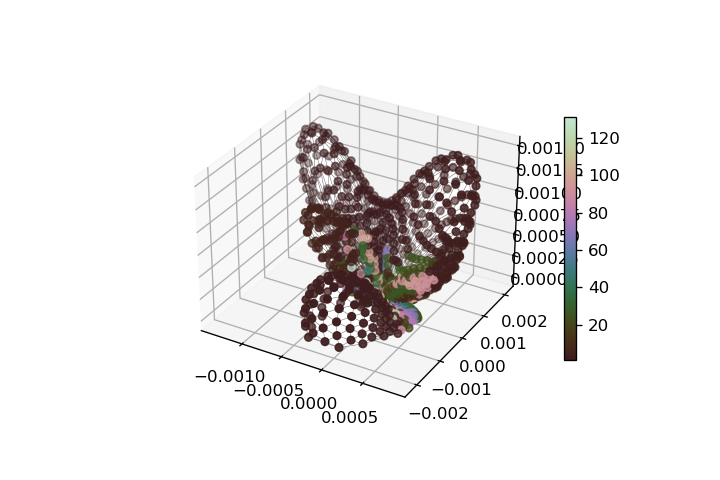

In [133]:
# Visualize lobe segmentation result
# Plot 3D surface of odf.
%matplotlib widget

# "surface" or "points"
to_plot = "points"
post_seg_filter = False

viz_sphere = sphere
viz_theta, viz_phi = pitn.odf.get_torch_sample_sphere_coords(
    viz_sphere, coeffs.device, coeffs.dtype
)
polar_tri = mpl.tri.Triangulation(viz_phi, viz_theta)
polar_tri_idx = torch.from_numpy(polar_tri.triangles).long()

# Take labels from pre-segmentation filtering.
if not post_seg_filter:
    viz_tri_labels = lobe_labels.flatten()[polar_tri_idx]
else:
    # Take labels from post-segmentation filtering.
    viz_tri_labels = ll.flatten()[polar_tri_idx]

label_cmap = sns.cubehelix_palette(
    n_colors=len(np.unique(viz_tri_labels.flatten())), reverse=True, rot=2, as_cmap=True
)
# viz_tri_labels = torch.mean(viz_tri_labels.float(), dim=1)
viz_tri_labels = torch.median(viz_tri_labels, dim=1).values

with torch.no_grad():
    viz_coeffs = coeffs[(slice(None),) + vox_idx][:, None, None, None]
    viz_mask = mask[(slice(None),) + vox_idx][:, None, None, None]
    # Function applies non-negativity constraint.
    viz_sphere_samples = pitn.odf.sample_sphere_coords(
        viz_coeffs,
        theta=viz_theta,
        phi=viz_phi,
        sh_order=8,
        sh_order_dim=0,
        mask=viz_mask,
    )

viz_fodf = np.copy(viz_sphere_samples.detach().cpu().numpy().flatten())
viz_tri_labels = viz_tri_labels.detach().cpu().numpy().flatten()

viz_theta = viz_theta.detach().cpu().numpy().flatten()
viz_phi = viz_phi.detach().cpu().numpy().flatten()
directions, values, indices = dipy.direction.peak_directions(
    viz_fodf, viz_sphere, relative_peak_threshold=0.5, min_separation_angle=25
)
# viz_fodf[viz_fodf < values.min() * 0.3] = 1e-8
with mpl.rc_context({"figure.autolayout": False}):
    fig = plt.figure(dpi=120)

    ax = fig.add_subplot(projection="3d")

    vals = viz_fodf

    r = (vals - vals.min()) / (vals - vals.min()).max()
    r = vals / vals.sum()

    x = r * np.sin(viz_theta) * np.cos(viz_phi)
    y = r * np.sin(viz_theta) * np.sin(viz_phi)
    z = r * np.cos(viz_theta)
    mapper = mpl.cm.ScalarMappable(cmap=label_cmap)

    # center_colors = mapper.to_rgba(viz_tri_labels)
    # center_colors = np.where((viz_tri_labels == 0)[:, None], np.zeros_like(center_colors), center_colors)
    #     vertex_colors = mapper.to_rgba(ll.numpy().flatten()[polar_tri.edges])
    # polar_tri_idx = torch.from_numpy(polar_tri.triangles).long()
    # viz_tri_labels = ll.flatten()[polar_tri_idx]
    euclid_tri = mpl.tri.Triangulation(x, y, triangles=polar_tri.triangles)
    surf = ax.plot_trisurf(euclid_tri, z, linewidth=0.3, antialiased=True, zorder=4)

    if to_plot == "surface":
        face_colors = mapper.to_rgba(viz_tri_labels)
        face_colors = np.where(
            (viz_tri_labels == 0)[:, None], np.zeros_like(face_colors), face_colors
        )
        surf.set_fc(face_colors)
    elif to_plot == "points":
        surf.set_fc("white")
        surf.set_edgecolors([0.2, 0.2, 0.2, 0.5])
        if post_seg_filter:
            point_colors = mapper.to_rgba(ll.numpy().flatten())
            point_colors = np.where(
                (ll.numpy().flatten() == 0)[:, None],
                np.zeros_like(point_colors),
                point_colors,
            )
        else:
            point_colors = mapper.to_rgba(lobe_labels.numpy().flatten())
            point_colors = np.where(
                (lobe_labels.numpy().flatten() == 0)[:, None],
                np.zeros_like(point_colors),
                point_colors,
            )
        ax.scatter3D(x, y, z, c=point_colors, s=20, zorder=0.1)
    plt.colorbar(mapper, shrink=0.67)
    plt.show()

In [ ]:
# Plot colored points on the surface of a unit [hemi]sphere.
%matplotlib widget
sph = sphere
r = 1
x = r * np.sin(sph.theta) * np.cos(sph.phi)
y = r * np.sin(sph.theta) * np.sin(sph.phi)
z = r * np.cos(sph.theta)
with mpl.rc_context({"figure.autolayout": False}):
    fig = plt.figure(dpi=120)

    ax = fig.add_subplot(projection="3d")
    ax.scatter3D(x, y, zs=z, marker=".", edgecolors=None, alpha=0.5)

# fig.canvas.mpl_connect("close_event", on_close)

In [ ]:
# Plot 3D surface of odf.
%matplotlib widget

# sphere = dipy.data.get_sphere("repulsion200").subdivide(2)
viz_sphere = dipy.data.get_sphere("repulsion724").subdivide(2)
viz_theta, viz_phi = pitn.odf.get_torch_sample_sphere_coords(
    viz_sphere, coeffs.device, coeffs.dtype
)
polar_tri = mpl.tri.Triangulation(viz_phi, viz_theta)
polar_tri_idx = torch.from_numpy(polar_tri.triangles).long()
# Center coordinate of each triangle:
barycenter_spherical_coords = torch.mean(
    torch.stack([viz_phi[polar_tri_idx], viz_theta[polar_tri_idx]], dim=1), dim=2
)
# Set the center coordinate to just be the 0'th vertex in each triangle.
# barycenter_spherical_coords = torch.stack(
#         [viz_phi[polar_tri_idx], viz_theta[polar_tri_idx]],
#         dim=1)[:, :, 0]
center_theta = barycenter_spherical_coords[:, 1]
center_phi = barycenter_spherical_coords[:, 0]
# vox_idx = cc_lr_lobe_idx
vox_idx = lr_and_ap_bipolar_lobe_idx
# vox_idx = tri_polar_lobe_idx
with torch.no_grad():
    viz_coeffs = coeffs[(slice(None),) + vox_idx][:, None, None, None]
    viz_mask = mask[(slice(None),) + vox_idx][:, None, None, None]
    # Function applies non-negativity constraint.
    viz_sphere_samples = pitn.odf.sample_sphere_coords(
        viz_coeffs,
        theta=viz_theta,
        phi=viz_phi,
        sh_order=8,
        sh_order_dim=0,
        mask=viz_mask,
    )
    viz_tri_center_samples = pitn.odf.sample_sphere_coords(
        viz_coeffs,
        theta=center_theta,
        phi=center_phi,
        sh_order=8,
        sh_order_dim=0,
        mask=viz_mask,
    )

viz_fodf = viz_sphere_samples.detach().cpu().numpy().flatten()
viz_tri_center_fodf = viz_tri_center_samples.detach().cpu().numpy().flatten()
viz_tri_center_theta = center_theta.detach().cpu().numpy().flatten()
viz_tri_center_phi = center_phi.detach().cpu().numpy().flatten()

viz_theta = viz_theta.detach().cpu().numpy().flatten()
viz_phi = viz_phi.detach().cpu().numpy().flatten()
directions, values, indices = dipy.direction.peak_directions(
    viz_fodf, viz_sphere, relative_peak_threshold=0.5, min_separation_angle=25
)
viz_fodf[viz_fodf < values.min() * 0.3] = 1e-8
with mpl.rc_context({"figure.autolayout": False}):
    fig = plt.figure(dpi=120)

    ax = fig.add_subplot(projection="3d")

    vals = viz_fodf

    r = (vals - vals.min()) / (vals - vals.min()).max()
    r = vals / vals.sum()

    x = r * np.sin(viz_theta) * np.cos(viz_phi)
    y = r * np.sin(viz_theta) * np.sin(viz_phi)
    z = r * np.cos(viz_theta)

    norm = mpl.colors.Normalize(
        vmin=viz_tri_center_fodf.min(), vmax=viz_tri_center_fodf.max()
    )
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap="gnuplot")
    center_colors = mapper.to_rgba(viz_tri_center_fodf)
    # face_colors = mapper.to_rgba(r)
    # face_colors = np.random.uniform(0.0, 1.0, size=face_colors.shape)
    # face_colors[:, 3] = 1.0
    euclid_tri = mpl.tri.Triangulation(x, y, triangles=polar_tri.triangles)
    # ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap="gnuplot", alpha=1, linewidth=0)
    # surf = ax.plot_trisurf(tri, z, antialiased=False, linewidth=0, cmap='gnuplot')
    surf = ax.plot_trisurf(euclid_tri, z, antialiased=False, linewidth=0)
    surf.set_fc(center_colors)
    plt.colorbar(mapper, shrink=0.67)

In [ ]:
%matplotlib inline
plt.figure(dpi=200)
norm = mpl.colors.Normalize(vmin=r.min(), vmax=r.max())
mapper = mpl.cm.ScalarMappable(norm=norm, cmap="gnuplot")
face_colors = mapper.to_rgba(r)
plt.triplot(polar_tri, lw=0.3, alpha=0.7)
# plt.scatter(viz_phi, viz_theta, s=4, c=face_colors, marker='.')
centers = np.mean(
    np.stack([viz_phi[polar_tri.triangles], viz_theta[polar_tri.triangles]], axis=1),
    axis=2,
)
center_vals = mpl.tri.LinearTriInterpolator(polar_tri, r)(centers[:, 0], centers[:, 1])
center_colors = mapper.to_rgba(center_vals)
plt.scatter(centers[:, 0], centers[:, 1], c=center_colors, marker=".", s=0.2)
# plt.colorbar()

#### FMLS Vectorized

##### PyTorch (Failed!)

In [ ]:
def unbatched_fmls_fodf_seg(
    sphere_sample: torch.Tensor,
    peak_diff_threshold: float,
    min_lobe_pdf_peak_threshold: float,
    min_lobe_pdf_integral_threshold: float,
    min_sample_pdf_threshold: float = 0.001,
) -> torch.Tensor:

    # From
    # R. E. Smith, J.-D. Tournier, F. Calamante, and A. Connelly,
    # "SIFT: Spherical-deconvolution informed filtering of tractograms," NeuroImage,
    # vol. 67, pp. 298–312, Feb. 2013, doi: 10.1016/j.neuroimage.2012.11.049.

    # Algorithm 1. in Appendix A of the SIFT paper.
    # peak_diff_threshold = 0.8
    # min_lobe_pdf_peak_threshold = 1e-5
    # min_lobe_pdf_integral_threshold = 0.05

    # s = torch.clone(sphere_samples[(slice(None),) + vox_idx])
    s = sphere_sample

    # Perform basic thresholding of the sample to remove noise.
    # Normalize to a pdf to keep threshold values standardized across fodfs.
    s_pdf = s - s.min()
    s_pdf = s_pdf / s_pdf.sum()
    s = torch.where(s_pdf >= min_sample_pdf_threshold, s, 0)
    s_pdf = s - s.min()
    s_pdf = s_pdf / s_pdf.sum()

    lobe_labels = torch.zeros_like(s).to(torch.int16)
    lobe_labels_index_space = torch.arange(lobe_labels.shape[0])

    # Directions are sorted by absolute value, but the sign of their absolute value
    # will be needed later.
    # Get the indices of the sorted sample values, with each idx indexing into the
    # directions/sample values on the spherical function.
    sort_sample_idx = torch.argsort(torch.abs(s), dim=0, descending=True)
    sort_sample_val = torch.gather(s, 0, sort_sample_idx)

    # curr_max_lobe_label = lobe_labels.new_tensor([0])
    curr_max_lobe_label = torch.tensor([0]).to(lobe_labels)
    for i_sample, fod_sample, sample_idx in zip(
        range(s.shape[-1]),
        sort_sample_val[..., None],
        sort_sample_idx[..., None],
    ):
        i_sample_mask = lobe_labels_index_space == sample_idx
        # Get the 6 directions closest to the current sample direction by providing the
        # current sample's index over the spherical function samples. These adjacent
        # indices correspond to the unsorted sample values and unsorted theta/phi sphereical
        # coordinates.
        sample_adj_idx = nearest_sphere_samples_idx[sample_idx].flatten()
        sample_adj = torch.gather(s, 0, sample_adj_idx)
        # Adjacent lobe labels
        lobe_label_adj = torch.gather(lobe_labels, 0, sample_adj_idx)
        # Some adjacent samples should not be considered such as when taking a sample from
        # a hemisphere near the equator.
        sample_adj_valid = nearest_sphere_samples_valid_mask[sample_idx].squeeze(0)

        lobe_label_adj = lobe_label_adj * sample_adj_valid
        # Find the number of adjacent lobes in such a way that is compatible with
        # functorch.vmap().
        # Sort the lobe labels themselves and and take the diff. The number of non-zero
        # diffs is equal to the number of unique labels, +/- 1. The +/- 1 is determined
        # by whether or not a $label_{l=0} - label_{l\neq0}$ is responsible for one of the
        # diffs being non-zero.
        n_unique_adj_lobe_labels = (
            (torch.diff(lobe_label_adj.sort().values) != 0).sum()
            + 1
            - 1 * (lobe_label_adj == 0).any(-1)  # indicator for any 0s being present.
        )

        # Now handle the 3 conditionals without any 'if' statements!
        # 1. If no lobes are adjacent to this sample.
        no_lobes_adj = torch.atleast_1d(n_unique_adj_lobe_labels == 0)
        no_lobes_adj = i_sample_mask * no_lobes_adj
        # If 0 lobes are adjacent, create a new lobe label and iterate on it.
        # The masked_scatter_ in-place function is the best way to do assignment without
        # casting Tensor indices to tuples, while combining multiple conditions...
        lobe_labels.masked_scatter_(no_lobes_adj, curr_max_lobe_label + 1)
        # curr_max_lobe_label.masked_scatter_(
        #     no_lobes_adj.any(-1), curr_max_lobe_label + 1
        # )
        curr_max_lobe_label = torch.masked_scatter(
            curr_max_lobe_label, no_lobes_adj.any(-1), curr_max_lobe_label + 1
        )
        # 2. If 1 lobe is adjacent to this sample.
        one_lobe_adj = torch.atleast_1d(n_unique_adj_lobe_labels == 1)
        one_lobe_adj = i_sample_mask * one_lobe_adj
        # If only 1 lobe is adjacent, assign the max (i.e., non-zero) adj lobe label.
        lobe_labels.masked_scatter_(one_lobe_adj, lobe_label_adj.max())

        # 3. If > 1 lobe is adjacent to this sample.
        else_gt_1_lobe_adj = torch.atleast_1d(n_unique_adj_lobe_labels > 1)
        else_gt_1_lobe_adj = i_sample_mask * else_gt_1_lobe_adj
        # A 2D mask of n_samples x m_adj_samples can contain a label value/mask of all
        # samples that correspond to a label value, for all adjacent samples.
        adj_lobe_sample_mask = (
            lobe_labels.expand(lobe_label_adj.shape[-1], -1).T == lobe_label_adj
        ) * (lobe_label_adj != 0)
        # For the samples adjacent to sample i, collect the samples that have previously
        # been assigned a valid label.
        samples_of_adj_lobe_labels = torch.masked_fill(
            s.expand(lobe_label_adj.shape[-1], -1).T, ~adj_lobe_sample_mask, torch.nan
        )
        # Equivilent to a `nanmax` function.
        adj_peaks = torch.nanquantile(samples_of_adj_lobe_labels, 1.0, dim=0)
        adj_peaks = torch.nan_to_num(adj_peaks, nan=-torch.inf)
        # adj_peaks = torch.masked.amax(samples_of_adj_lobe_labels, dim=-1)
        adj_lobe_labels_idx_sorted_by_peaks = torch.argsort(adj_peaks)
        # The min lobe label must not be 0, so we need to select the first non-zero lobe
        # label. If there are 0 or 1 adjacent lobes, then we won't actually use this result,
        # and instead consider *all* as unique lobes, and just grab a dummy index instead.
        # Indexes into the original list of adjacent samples/directions.
        min_lobe_label_adj_idx = torch.cat(
            torch.where(
                ~else_gt_1_lobe_adj.any(
                    -1
                )  # prevents empty tensors when <= 1 adj lobes
                | (lobe_label_adj[adj_lobe_labels_idx_sorted_by_peaks] != 0)
            ),
        )[0]
        # Need both the smallest adjacent lobe (and its label), and the peak of that lobe.
        min_lobe_label_adj = torch.gather(
            lobe_label_adj[adj_lobe_labels_idx_sorted_by_peaks],
            0,
            min_lobe_label_adj_idx,
        )
        min_lobe_adj_peak = torch.gather(
            adj_peaks[adj_lobe_labels_idx_sorted_by_peaks], 0, min_lobe_label_adj_idx
        )
        # We know that there exist at least 2 valid lobe labels, so select the label
        # with the max peak.
        max_lobe_label_adj = lobe_label_adj[adj_lobe_labels_idx_sorted_by_peaks][-1]
        r = fod_sample / min_lobe_adj_peak.clamp_min(1e-6)
        # 3.1 The difference between the current sample and the smallest peak of the
        # adjacent lobes is < the user-defined threshold.
        lobe_labels.masked_scatter_(
            else_gt_1_lobe_adj & (r < peak_diff_threshold), max_lobe_label_adj
        )

        # 3.2 Same comparison as 3.1, but >= the user-defined threshold.
        # Merge into the largest adjacent lobe, to keep the lobe indices sorted by peak
        # values.
        lobe_labels.masked_scatter_(
            else_gt_1_lobe_adj & (r >= peak_diff_threshold), max_lobe_label_adj
        )
        # If the sample_i has > 1 adjacent lobes
        # AND the ratio exceeds the threshold
        # AND for each lobe label, is the label in the set of adjacent labels
        # AND for each lobe label, is the label not 0
        # then assign to the largest adjacent lobe.
        lobe_labels.masked_scatter_(
            else_gt_1_lobe_adj.any(-1)
            & (r >= peak_diff_threshold)
            & torch.isin(lobe_labels, lobe_label_adj)
            & (lobe_labels != 0),
            max_lobe_label_adj.expand(lobe_labels.shape[-1]),
        )

    return lobe_labels

In [ ]:
# Single voxel lobe segmentation
vox_idx = cc_lr_lobe_idx
# vox_idx = lr_and_ap_bipolar_lobe_idx
# vox_idx = tri_polar_lobe_idx

peak_diff_threshold = 0.8
min_lobe_pdf_peak_threshold = 1e-5
min_lobe_pdf_integral_threshold = 0.05

s = torch.clone(sphere_samples[(slice(None),) + vox_idx])

ll = unbatched_fmls_fodf_seg(
    s,
    peak_diff_threshold=peak_diff_threshold,
    min_lobe_pdf_peak_threshold=min_lobe_pdf_peak_threshold,
    min_lobe_pdf_integral_threshold=min_lobe_pdf_integral_threshold,
)
print(ll.unique())

In [ ]:
#! Does not work!
# v0_idx = lr_and_ap_bipolar_lobe_idx
# v1_idx = cc_lr_lobe_idx
# s = torch.stack(
#     [sphere_samples[(slice(None),) + v0_idx], sphere_samples[(slice(None),) + v1_idx]]
# )
# b_ll = functorch.vmap(unbatched_fmls_fodf_seg)(
#     s,
#     peak_diff_threshold=peak_diff_threshold,
#     min_lobe_pdf_peak_threshold=min_lobe_pdf_peak_threshold,
#     min_lobe_pdf_integral_threshold=min_lobe_pdf_integral_threshold,
# )

##### Jax
torch -> dlpack -> jax -> dlpack -> torch

In [140]:
def _jax_unbatched_fmls_fodf_seg(
    sphere_sample: jax.Array,
    nearest_sphere_samples_idx: jax.Array,
    nearest_sphere_samples_valid_mask: jax.Array,
    peak_diff_threshold: float,
) -> jax.Array:

    # From
    # R. E. Smith, J.-D. Tournier, F. Calamante, and A. Connelly,
    # "SIFT: Spherical-deconvolution informed filtering of tractograms," NeuroImage,
    # vol. 67, pp. 298–312, Feb. 2013, doi: 10.1016/j.neuroimage.2012.11.049.
    # Algorithm 1. in Appendix A.
    s = sphere_sample

    lobe_labels = jnp.zeros_like(s, dtype=jnp.int16)
    lobe_labels_index_space = jnp.arange(lobe_labels.shape[0])
    # Directions are sorted by absolute value, but the sign of their absolute value
    # will be needed later.
    # Get the indices of the sorted sample values, with each idx indexing into the
    # directions/sample values on the spherical function.
    sort_sample_idx = jnp.flip(jnp.argsort(jnp.abs(s)).astype(jnp.int16))
    sort_sample_val = jnp.take(s, sort_sample_idx)

    curr_max_lobe_label = 0

    def fmls_loop_body_fn(
        i_sample: int,
        state: dict,
        s,
        peak_diff_threshold,
        sort_sample_val,
        sort_sample_idx,
        lobe_labels_index_space,
        nearest_sphere_samples_idx,
        nearest_sphere_samples_valid_mask,
    ) -> dict:

        lobe_labels = state["lobe_labels"]
        curr_max_lobe_label = state["curr_max_lobe_label"]

        # i_sample gives the array index in the *sorted* fod samples, but we also need
        # the current sample's index from the original *unsorted* array of fod samples.
        idx_in_unsort_samples = sort_sample_idx[i_sample]

        # Get the 6 directions closest to the current sample direction by providing the
        # current sample's index over the spherical function samples. These adjacent
        # indices correspond to the unsorted sample values and unsorted theta/phi sphereical
        # coordinates.
        sample_adj_idx = nearest_sphere_samples_idx[idx_in_unsort_samples]
        sample_adj = jnp.take(s, sample_adj_idx)
        # Adjacent lobe labels
        adj_lobe_label = jnp.take(lobe_labels, sample_adj_idx)
        # Some adjacent samples should not be considered such as when taking a sample from
        # a hemisphere near the equator.
        sample_adj_valid = nearest_sphere_samples_valid_mask[idx_in_unsort_samples]

        adj_lobe_label = adj_lobe_label * sample_adj_valid
        # Find the number of adjacent lobes in such a way that is compatible with
        # auto vectorization.
        # Sort the lobe labels themselves and and take the diff. The number of non-zero
        # diffs is equal to the number of unique labels, +/- 1. The +/- 1 is determined
        # by whether or not a $label_{l=0} - label_{l\neq0}$ is responsible for one of the
        # diffs being non-zero.
        n_unique_adj_lobe_labels = (
            (jnp.diff(adj_lobe_label.sort()) != 0).sum()
            + 1
            - 1 * (adj_lobe_label == 0).any()  # indicator for any 0s being present.
        )

        # Now handle the 3 conditionals without any explicit 'if' statements!
        # 1. If no lobes are adjacent to this sample.
        def zero_lobes_adj_fn(
            s,
            peak_diff_threshold,
            idx_in_unsort_samples,
            adj_lobe_label,
            lobe_labels,
            curr_max_lobe_label,
        ) -> dict:
            # If 0 lobes are adjacent, create a new lobe label and iterate on it.
            lobe_labels = lobe_labels.at[idx_in_unsort_samples].set(
                curr_max_lobe_label + 1
            )
            curr_max_lobe_label = curr_max_lobe_label + 1

            return dict(
                lobe_labels=lobe_labels, curr_max_lobe_label=curr_max_lobe_label
            )

        # 2. If 1 lobe is adjacent to this sample.
        def one_lobe_adj_fn(
            s,
            peak_diff_threshold,
            idx_in_unsort_samples,
            adj_lobe_label,
            lobe_labels,
            curr_max_lobe_label,
        ) -> dict:
            # If only 1 lobe is adjacent, assign the max (i.e., non-zero) adj lobe label.
            only_adj_label = adj_lobe_label.max()
            lobe_labels = lobe_labels.at[idx_in_unsort_samples].set(only_adj_label)
            return dict(
                lobe_labels=lobe_labels, curr_max_lobe_label=curr_max_lobe_label
            )

        # 3. If > 1 lobe is adjacent to this sample.
        def gt_one_lobe_adj_fn(
            s,
            peak_diff_threshold,
            idx_in_unsort_samples,
            adj_lobe_label,
            lobe_labels,
            curr_max_lobe_label,
        ) -> dict:

            # A 2D mask of n_samples x m_adj_samples can contain a label value/mask of all
            # samples that correspond to a label value, for all labels in adjacent
            # samples.
            max_num_adj_lobes = adj_lobe_label.shape[-1]
            adj_lobe_sample_mask = (
                jnp.tile(lobe_labels, (max_num_adj_lobes, 1)).T == adj_lobe_label
            ) * (adj_lobe_label != 0)
            # adj_lobe_sample_mask = (
            #     lobe_labels.expand(adj_lobe_label.shape[-1], -1).T == adj_lobe_label
            # ) * (adj_lobe_label != 0)
            # For the samples adjacent to sample i, collect the samples that have previously
            # been assigned a valid label.
            samples_of_adj_lobe_labels = jnp.where(
                ~adj_lobe_sample_mask, jnp.tile(s, (max_num_adj_lobes, 1)).T, jnp.nan
            )
            # samples_of_adj_lobe_labels = torch.masked_fill(
            #     s.expand(adj_lobe_label.shape[-1], -1).T, ~adj_lobe_sample_mask, torch.nan
            # )
            # Take the max sample value over each adjacent lobe label, even the
            # "invalid" labels (=0).
            adj_peaks = jnp.nanmax(samples_of_adj_lobe_labels, axis=0)
            # adj_peaks = torch.nanquantile(samples_of_adj_lobe_labels, 1.0, dim=0)
            # adj_peaks = jnp.nan_to_num(adj_peaks, nan=-jnp.inf)
            # adj_peaks = torch.masked.amax(samples_of_adj_lobe_labels, dim=-1)
            # adj_lobe_labels_idx_sorted_by_peaks = torch.argsort(adj_peaks)
            # The min lobe label must not be 0, so we need to select the first non-zero lobe
            # label.
            min_adj_lobe_label_idx = jnp.nanargmin(adj_peaks)
            # min_adj_lobe_label_idx = torch.cat(
            #     torch.where(
            #         ~else_gt_1_lobe_adj.any(
            #             -1
            #         )  # prevents empty tensors when <= 1 adj lobes
            #         | (adj_lobe_label[adj_lobe_labels_idx_sorted_by_peaks] != 0)
            #     ),
            # )[0]
            # Need both the smallest adjacent lobe (and its label), and the peak of that lobe.
            min_adj_lobe_label = adj_lobe_label[min_adj_lobe_label_idx]
            min_adj_lobe_peak = adj_peaks[min_adj_lobe_label_idx]
            # min_adj_lobe_label = torch.gather(
            #     adj_lobe_label[adj_lobe_labels_idx_sorted_by_peaks],
            #     0,
            #     min_adj_lobe_label_idx,
            # )
            # min_lobe_adj_peak = torch.gather(
            #     adj_peaks[adj_lobe_labels_idx_sorted_by_peaks],
            #     0,
            #     min_adj_lobe_label_idx,
            # )
            max_adj_lobe_label = adj_lobe_label[jnp.nanargmax(adj_peaks)]
            # max_adj_lobe_label = adj_lobe_label[adj_lobe_labels_idx_sorted_by_peaks][-1]
            fod_sample = s[idx_in_unsort_samples]
            r = fod_sample / jnp.clip(min_adj_lobe_peak, 1e-6, jnp.inf)

            # 3.1 The difference between the current sample and the smallest peak of the
            # adjacent lobes is < the user-defined threshold.
            def _assign_largest(lobe_l, s_idx, adj_s_mask, large_l):
                return lobe_l.at[s_idx].set(large_l)

            # 3.2 Same comparison as 3.1, but >= the user-defined threshold.
            # Merge into the largest adjacent lobe, to keep the lobe indices sorted by peak
            # values.
            def _merge_adj(lobe_l, s_idx, adj_s_mask, large_l):
                return jnp.where(adj_s_mask.at[s_idx].set(True), large_l, lobe_l)

            lobe_labels = lax.cond(
                r < peak_diff_threshold,
                _assign_largest,
                _merge_adj,
                lobe_labels,
                idx_in_unsort_samples,
                jnp.sometrue(adj_lobe_sample_mask, axis=1),  # Collapse adj labels.
                max_adj_lobe_label,
            )
            # lobe_labels.masked_scatter_(
            #     else_gt_1_lobe_adj & (r < peak_diff_threshold), max_adj_lobe_label
            # )

            # lobe_labels.masked_scatter_(
            #     else_gt_1_lobe_adj & (r >= peak_diff_threshold), max_adj_lobe_label
            # )
            # # If the sample_i has > 1 adjacent lobes
            # # AND the ratio exceeds the threshold
            # # AND for each lobe label, is the label in the set of adjacent labels
            # # AND for each lobe label, is the label not 0
            # # then assign to the largest adjacent lobe.
            # lobe_labels.masked_scatter_(
            #     else_gt_1_lobe_adj.any(-1)
            #     & (r >= peak_diff_threshold)
            #     & torch.isin(lobe_labels, adj_lobe_label)
            #     & (lobe_labels != 0),
            #     max_adj_lobe_label.expand(lobe_labels.shape[-1]),
            # )
            return dict(
                lobe_labels=lobe_labels, curr_max_lobe_label=curr_max_lobe_label
            )

        segment_state_i = lax.switch(
            jnp.clip(n_unique_adj_lobe_labels, 0, 2),
            (zero_lobes_adj_fn, one_lobe_adj_fn, gt_one_lobe_adj_fn),
            s,
            peak_diff_threshold,
            idx_in_unsort_samples,
            adj_lobe_label,
            lobe_labels,
            curr_max_lobe_label,
        )
        lobe_labels_i = segment_state_i["lobe_labels"]
        curr_max_lobe_label_i = segment_state_i["curr_max_lobe_label"]

        return dict(
            lobe_labels=lobe_labels_i, curr_max_lobe_label=curr_max_lobe_label_i
        )

    state_0 = dict(
        lobe_labels=lobe_labels,
        curr_max_lobe_label=curr_max_lobe_label,
    )
    # Most parameters are constant over the loop, so just fill those in with a partial
    # function call.
    body_fn_with_consts = partial(
        fmls_loop_body_fn,
        s=s,
        peak_diff_threshold=peak_diff_threshold,
        sort_sample_val=sort_sample_val,
        sort_sample_idx=sort_sample_idx,
        lobe_labels_index_space=lobe_labels_index_space,
        nearest_sphere_samples_idx=nearest_sphere_samples_idx,
        nearest_sphere_samples_valid_mask=nearest_sphere_samples_valid_mask,
    )

    state_t = lax.fori_loop(
        0, s.shape[0], body_fun=body_fn_with_consts, init_val=state_0
    )
    lobe_labels = state_t["lobe_labels"]

    return lobe_labels

In [134]:
# Single voxel lobe segmentation
# vox_idx = cc_lr_lobe_idx
# vox_idx = lr_and_ap_bipolar_lobe_idx
vox_idx = tri_polar_lobe_idx

peak_diff_threshold = 0.8
min_lobe_pdf_peak_threshold = 1e-5
min_lobe_pdf_integral_threshold = 0.05
min_sample_pdf_threshold = 0.001

s = torch.clone(sphere_samples[(slice(None),) + vox_idx])
# Perform basic thresholding of the sample to remove noise.
# Normalize to a pdf to keep threshold values standardized across fodfs.
s_pdf = s - s.min()
s_pdf = s_pdf / s_pdf.sum()
s = torch.where(s_pdf < min_sample_pdf_threshold, 0, s)
s_pdf = s - s.min()
s_pdf = s_pdf / s_pdf.sum()

sjx = jax.dlpack.from_dlpack(torch.utils.dlpack.to_dlpack(s))

near_sph_samples_idx_jx = jax.dlpack.from_dlpack(
    torch.utils.dlpack.to_dlpack(nearest_sphere_samples_idx.contiguous())
)
near_sph_samples_valid_mask_jx = jax.dlpack.from_dlpack(
    torch.utils.dlpack.to_dlpack(
        nearest_sphere_samples_valid_mask.contiguous().to(torch.int8)
    )
).astype(bool)

ll_jax = _jax_unbatched_fmls_fodf_seg(
    sjx,
    nearest_sphere_samples_idx=near_sph_samples_idx_jx,
    nearest_sphere_samples_valid_mask=near_sph_samples_valid_mask_jx,
    peak_diff_threshold=peak_diff_threshold,
)
print(ll_jax)
np.unique(ll_jax)

[11  2  0 ... 17 16 16]


array([ 0,  1,  2,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53], dtype=int16)

In [141]:
jax_batched_fmls_fodf_seg_fn = jax.jit(
    jax.vmap(_jax_unbatched_fmls_fodf_seg, in_axes=(0, None, None, None))
)
# jax transformed functions force in_axes=0 for all keyword-passed arguments! So, all
# non-batched-over arguments must be passed by position! (Something to do with the
# difficulty/fragility in parsing argument position in a function call in Python?)
batched_ll_jax = jax_batched_fmls_fodf_seg_fn(
    jnp.stack([sjx, sjx], 0),
    near_sph_samples_idx_jx,
    near_sph_samples_valid_mask_jx,
    peak_diff_threshold,
)
print(batched_ll_jax)
print(batched_ll_jax.shape)
print(jnp.unique(batched_ll_jax))

[[11  2  0 ... 17 16 16]
 [11  2  0 ... 17 16 16]]
(2, 1445)
[ 0  1  2  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53]


In [124]:
batched_ll = torch.utils.dlpack.from_dlpack(
    jax.dlpack.to_dlpack(batched_ll_jax, take_ownership=True)
)
batch_s = torch.stack([s, s], 0)
batch_s_pdf = torch.stack([s_pdf, s_pdf], 0)

In [125]:
###! The below code does not work with vmap()
# Filter out lobes that don't meet some criteria
pre_filter_lobe_labels = torch.clone(batched_ll)
ll = torch.clone(batched_ll)
orig_unique_ll = ll.unique(dim=1)
lobe_peaks = torch.zeros_like(orig_unique_ll).float()
lobe_integrals = torch.zeros_like(orig_unique_ll).float()
lobe_pdf_peaks = torch.zeros_like(orig_unique_ll).float()
lobe_pdf_integrals = torch.zeros_like(orig_unique_ll).float()
for i in range(orig_unique_ll.shape[1]):
    l = orig_unique_ll[:, i, None]
    # print(l.item(), end=" ")
    select_s = torch.where(ll == l, batch_s, torch.nan)
    select_s_pdf = torch.where(ll == l, batch_s_pdf, torch.nan)
    # print(ll == l, end=" ")
    lobe_peaks[:, i] = torch.nanquantile(select_s, 1.0, dim=1)
    lobe_pdf_peaks[:, i] = torch.nanquantile(select_s_pdf, 1.0, dim=1)
    # print(lobe_peaks[:, i], end=" ")
    lobe_integrals[:, i] = torch.nansum(select_s, dim=1)
    lobe_pdf_integrals[:, i] = torch.nansum(select_s_pdf, dim=1)
    lobe_labels_to_remove_mask = ~(select_s.isnan()) & (
        (lobe_pdf_peaks[:, i, None] < min_lobe_pdf_peak_threshold)
        | (lobe_pdf_integrals[:, i, None] < min_lobe_pdf_integral_threshold)
    )
    ll[lobe_labels_to_remove_mask] = 0

    new_select_s = torch.where((ll == l) & (ll != 0), batch_s, torch.nan)
    new_select_s_pdf = torch.where((ll == l) & (ll != 0), batch_s_pdf, torch.nan)
    # print(ll == l, end=" ")
    lobe_peaks[:, i] = torch.nanquantile(new_select_s, 1.0, dim=1)
    lobe_pdf_peaks[:, i] = torch.nanquantile(new_select_s, 1.0, dim=1)
lobe_peaks.nan_to_num_(nan=-torch.inf)
lobe_pdf_peaks.nan_to_num_(nan=0)

# Re-map labels to be evenly-spaced, ascending index, in order of largest lobe
# peak to smallest lobe peak. Performs batch-wise.
sorted_lobe_peaks_idx = torch.argsort(lobe_peaks, dim=1, descending=True)
sorted_lobe_peaks = lobe_peaks.gather(1, sorted_lobe_peaks_idx)
sorted_lobe_labels = orig_unique_ll.gather(1, sorted_lobe_peaks_idx)
i = 0
new_label = 1
reduced_lobe_peak_i = sorted_lobe_peaks[:, i, None]
reduced_lobe_label_i = sorted_lobe_labels[:, i, None]
while not reduced_lobe_peak_i.isneginf().all():
    ll.masked_fill_(ll == reduced_lobe_label_i, new_label)
    new_label += 1
    i += 1
    reduced_lobe_label_i = sorted_lobe_labels[:, i, None]
    reduced_lobe_peak_i = sorted_lobe_peaks[:, i, None]

print(ll)
print(ll.unique())

for l in ll.unique():
    if l.item() == 0:
        continue
    print("l:", l.item())
    print("\tpeak ", (batch_s * (ll == l)).max(1).values)
    print("\tintegral ", (batch_s * (ll == l)).sum(1))
    print("\tPDF peak ", (batch_s_pdf * (ll == l)).max(1).values)
    print("\tPDF integral ", (batch_s_pdf * (ll == l)).sum(1))

tensor([[0, 2, 0,  ..., 0, 0, 0],
        [0, 2, 0,  ..., 0, 0, 0]], dtype=torch.int16)
tensor([0, 1, 2, 3, 4, 5], dtype=torch.int16)
l: 1
	peak  tensor([0.1474, 0.1474], dtype=torch.float64)
	integral  tensor([14.1366, 14.1366], dtype=torch.float64)
	PDF peak  tensor([0.0033, 0.0033], dtype=torch.float64)
	PDF integral  tensor([0.3145, 0.3145], dtype=torch.float64)
l: 2
	peak  tensor([0.1451, 0.1451], dtype=torch.float64)
	integral  tensor([7.1569, 7.1569], dtype=torch.float64)
	PDF peak  tensor([0.0032, 0.0032], dtype=torch.float64)
	PDF integral  tensor([0.1592, 0.1592], dtype=torch.float64)
l: 3
	peak  tensor([0.1223, 0.1223], dtype=torch.float64)
	integral  tensor([4.1553, 4.1553], dtype=torch.float64)
	PDF peak  tensor([0.0027, 0.0027], dtype=torch.float64)
	PDF integral  tensor([0.0924, 0.0924], dtype=torch.float64)
l: 4
	peak  tensor([0.1148, 0.1148], dtype=torch.float64)
	integral  tensor([2.6586, 2.6586], dtype=torch.float64)
	PDF peak  tensor([0.0026, 0.0026], dtype=torch.fl

In [126]:
dipy.direction.peak_directions(
    s.numpy(), sphere, relative_peak_threshold=0.4, min_separation_angle=20
)

(array([[-0.56776445,  0.55963905,  0.60369501],
        [-0.09472737, -0.98444173,  0.14799059],
        [ 0.22250045,  0.75630032,  0.61522628],
        [-0.53674572, -0.45727477,  0.70908661]]),
 array([0.14742453, 0.1450631 , 0.14433149, 0.08951013]),
 array([862, 373,  83, 913]))

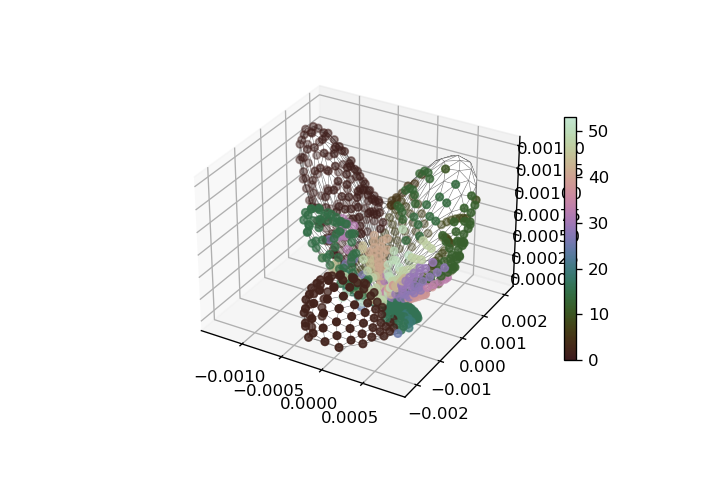

In [129]:
# Visualize lobe segmentation result
# Plot 3D surface of odf.
%matplotlib widget

# "surface" or "points"
to_plot = "points"
post_seg_filter = False

viz_sphere = sphere
viz_theta, viz_phi = pitn.odf.get_torch_sample_sphere_coords(
    viz_sphere, coeffs.device, coeffs.dtype
)
viz_ll = ll[0]
viz_pre_filter_ll = pre_filter_lobe_labels[0]
polar_tri = mpl.tri.Triangulation(viz_phi, viz_theta)
polar_tri_idx = torch.from_numpy(polar_tri.triangles).long()

# Take labels from pre-segmentation filtering.
if not post_seg_filter:
    viz_tri_labels = viz_pre_filter_ll.flatten()[polar_tri_idx]
else:
    # Take labels from post-segmentation filtering.
    viz_tri_labels = viz_ll.flatten()[polar_tri_idx]

label_cmap = sns.cubehelix_palette(
    n_colors=len(np.unique(viz_tri_labels.flatten())), reverse=True, rot=2, as_cmap=True
)
# viz_tri_labels = torch.mean(viz_tri_labels.float(), dim=1)
viz_tri_labels = torch.median(viz_tri_labels, dim=1).values

with torch.no_grad():
    viz_coeffs = coeffs[(slice(None),) + vox_idx][:, None, None, None]
    viz_mask = mask[(slice(None),) + vox_idx][:, None, None, None]
    # Function applies non-negativity constraint.
    viz_sphere_samples = pitn.odf.sample_sphere_coords(
        viz_coeffs,
        theta=viz_theta,
        phi=viz_phi,
        sh_order=8,
        sh_order_dim=0,
        mask=viz_mask,
    )

viz_fodf = np.copy(viz_sphere_samples.detach().cpu().numpy().flatten())
viz_tri_labels = viz_tri_labels.detach().cpu().numpy().flatten()

viz_theta = viz_theta.detach().cpu().numpy().flatten()
viz_phi = viz_phi.detach().cpu().numpy().flatten()
directions, values, indices = dipy.direction.peak_directions(
    viz_fodf, viz_sphere, relative_peak_threshold=0.5, min_separation_angle=25
)
# viz_fodf[viz_fodf < values.min() * 0.3] = 1e-8
with mpl.rc_context({"figure.autolayout": False}):
    fig = plt.figure(dpi=120)

    ax = fig.add_subplot(projection="3d")

    vals = viz_fodf

    r = (vals - vals.min()) / (vals - vals.min()).max()
    r = vals / vals.sum()

    x = r * np.sin(viz_theta) * np.cos(viz_phi)
    y = r * np.sin(viz_theta) * np.sin(viz_phi)
    z = r * np.cos(viz_theta)
    mapper = mpl.cm.ScalarMappable(cmap=label_cmap)

    # center_colors = mapper.to_rgba(viz_tri_labels)
    # center_colors = np.where((viz_tri_labels == 0)[:, None], np.zeros_like(center_colors), center_colors)
    #     vertex_colors = mapper.to_rgba(ll.numpy().flatten()[polar_tri.edges])
    # polar_tri_idx = torch.from_numpy(polar_tri.triangles).long()
    # viz_tri_labels = ll.flatten()[polar_tri_idx]
    euclid_tri = mpl.tri.Triangulation(x, y, triangles=polar_tri.triangles)
    surf = ax.plot_trisurf(euclid_tri, z, linewidth=0.3, antialiased=True, zorder=4)

    if to_plot == "surface":
        face_colors = mapper.to_rgba(viz_tri_labels)
        face_colors = np.where(
            (viz_tri_labels == 0)[:, None], np.zeros_like(face_colors), face_colors
        )
        surf.set_fc(face_colors)
    elif to_plot == "points":
        surf.set_fc("white")
        surf.set_edgecolors([0.2, 0.2, 0.2, 0.5])
        if post_seg_filter:
            point_colors = mapper.to_rgba(viz_ll.numpy().flatten())
            point_colors = np.where(
                (viz_ll.numpy().flatten() == 0)[:, None],
                np.zeros_like(point_colors),
                point_colors,
            )
        else:
            point_colors = mapper.to_rgba(viz_pre_filter_ll.numpy().flatten())
            point_colors = np.where(
                (viz_pre_filter_ll.numpy().flatten() == 0)[:, None],
                np.zeros_like(point_colors),
                point_colors,
            )
        ax.scatter3D(x, y, z, c=point_colors, s=20, zorder=0.1)
    plt.colorbar(mapper, shrink=0.67)
    plt.show()